# ANN vs SNN Equivalence Demo

This notebook demonstrates that a Spiking Neural Network (SNN) using Sigma-Delta neurons 
produces the same output as a traditional Artificial Neural Network (ANN) with ReLU activation,
when both networks have identical weights.

## Architecture

```
Input (3) → Hidden1 (4, ReLU) → Hidden2 (2, ReLU) → Output (1, ReLU)
```

## Key Insight

Sigma-Delta neurons work by:
1. **Delta encoder**: Encodes changes in input as sparse spikes
2. **Sigma decoder**: Accumulates spikes to reconstruct continuous values
3. **Activation**: Applies ReLU (same as ANN)


## 1. Setup and Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Lava imports
from lava.proc.io.source import RingBuffer as InputBuffer
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import Delta, SigmaDelta, ActivationMode
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

np.random.seed(123)
print("Imports successful!")


Imports successful!


## 2. Network Architecture and Weights

3-layer network with scalar output for clear visualization.


In [2]:
# Network dimensions: 3 -> 4 -> 2 -> 1 (scalar output)
INPUT_SIZE = 3
HIDDEN1_SIZE = 4
HIDDEN2_SIZE = 2
OUTPUT_SIZE = 1

# Weights designed for good signal propagation through ReLU
W1 = np.array([
    [ 0.8,  0.5, -0.2],
    [-0.3,  0.9,  0.4],
    [ 0.6, -0.1,  0.7],
    [ 0.4,  0.6,  0.5]
])

W2 = np.array([
    [ 0.7,  0.5,  0.3, -0.2],
    [-0.1,  0.6,  0.8,  0.4]
])

W3 = np.array([[ 0.9,  0.7]])

print("Network: Input(3) → Hidden1(4) → Hidden2(2) → Output(1)")
print(f"W1: {W1.shape}, W2: {W2.shape}, W3: {W3.shape}")


Network: Input(3) → Hidden1(4) → Hidden2(2) → Output(1)
W1: (4, 3), W2: (2, 4), W3: (1, 2)


## 3. ANN Implementation (NumPy)


In [3]:
def relu(x):
    """ReLU activation function"""
    return np.maximum(x, 0)


def ann_forward(x, w1, w2, w3):
    """Forward pass through 3-layer ANN with scalar output."""
    h1 = relu(w1 @ x)
    h2 = relu(w2 @ h1)
    y = relu(w3 @ h2)
    return y[0]  # Return scalar


# Quick test
test_input = np.array([0.5, 0.5, 0.5])
test_output = ann_forward(test_input, W1, W2, W3)
print(f"Test input: {test_input}")
print(f"ANN output: {test_output:.4f}")


Test input: [0.5 0.5 0.5]
ANN output: 1.3160


## 4. Generate Sinusoidal Input (100 samples)

We create a 3-channel input where each channel is a phase-shifted sine wave.


Input shape: (3, 120)
Total timesteps: 120 (warmup: 20, signal: 100)


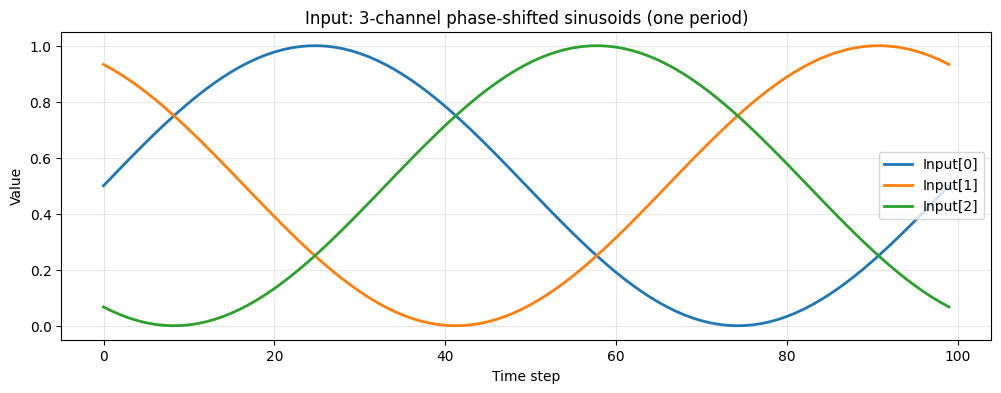

In [4]:
# Parameters
WARMUP = 20      # Warmup steps (constant input) for SNN to stabilize
T_SIN = 100      # Sinusoid samples (one full period)
T_TOTAL = WARMUP + T_SIN

# Generate sinusoidal input: one full period
t = np.linspace(0, 2 * np.pi, T_SIN)

sin_part = np.zeros((INPUT_SIZE, T_SIN))
sin_part[0] = (np.sin(t) + 1) / 2                # Channel 0: sin, range [0, 1]
sin_part[1] = (np.sin(t + 2*np.pi/3) + 1) / 2    # Channel 1: phase shifted
sin_part[2] = (np.sin(t + 4*np.pi/3) + 1) / 2    # Channel 2: phase shifted

# Warmup: repeat first value to let SNN stabilize
warmup_part = np.tile(sin_part[:, 0:1], (1, WARMUP))

# Full input: warmup + sinusoid
full_input = np.hstack([warmup_part, sin_part])

print(f"Input shape: {full_input.shape}")
print(f"Total timesteps: {T_TOTAL} (warmup: {WARMUP}, signal: {T_SIN})")

# Plot input signals
plt.figure(figsize=(12, 4))
for i in range(INPUT_SIZE):
    plt.plot(np.arange(T_SIN), sin_part[i], label=f'Input[{i}]', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input: 3-channel phase-shifted sinusoids (one period)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 5. Compute ANN Output


In [5]:
# Compute ANN output for all timesteps
ann_full = np.array([ann_forward(full_input[:, i], W1, W2, W3) for i in range(T_TOTAL)])

# Extract sinusoid part (after warmup)
ann_sin = ann_full[WARMUP:]

print(f"ANN output shape: {ann_sin.shape}")
print(f"ANN output range: [{ann_sin.min():.3f}, {ann_sin.max():.3f}]")


ANN output shape: (100,)
ANN output range: [1.181, 1.453]


## 6. Build and Run SNN (Sigma-Delta)

The SNN architecture:
```
Input → Delta(encode) → Dense(W1) → SigmaDelta → Dense(W2) → SigmaDelta → Dense(W3) → SigmaDelta → Output
```


In [6]:
# SNN Parameters
VTH = 0.01  # Sigma-Delta threshold (smaller = more accurate)

# Build SNN
source = InputBuffer(data=full_input)
inp_proj = Dense(weights=np.eye(INPUT_SIZE), num_message_bits=24)
inp_delta = Delta(shape=(INPUT_SIZE,), vth=VTH, cum_error=True)

dense1 = Dense(weights=W1, num_message_bits=24)
hidden1 = SigmaDelta(shape=(HIDDEN1_SIZE,), vth=VTH, act_mode=ActivationMode.RELU, cum_error=True)

dense2 = Dense(weights=W2, num_message_bits=24)
hidden2 = SigmaDelta(shape=(HIDDEN2_SIZE,), vth=VTH, act_mode=ActivationMode.RELU, cum_error=True)

dense3 = Dense(weights=W3, num_message_bits=24)
output = SigmaDelta(shape=(OUTPUT_SIZE,), vth=VTH, act_mode=ActivationMode.RELU, cum_error=True)

# Connect the network
source.s_out.connect(inp_proj.s_in)
inp_proj.a_out.connect(inp_delta.a_in)
inp_delta.s_out.connect(dense1.s_in)
dense1.a_out.connect(hidden1.a_in)
hidden1.s_out.connect(dense2.s_in)
dense2.a_out.connect(hidden2.a_in)
hidden2.s_out.connect(dense3.s_in)
dense3.a_out.connect(output.a_in)

# Monitor output
mon = Monitor()
mon.probe(output.act, T_TOTAL)

print("SNN built successfully!")


SNN built successfully!


In [7]:
# Run SNN simulation
output.run(
    condition=RunSteps(num_steps=T_TOTAL),
    run_cfg=Loihi2SimCfg(select_tag='floating_pt')
)

# Get recorded data
data = mon.get_data()
output.stop()

# Extract output trace
key = list(data.keys())[0]
snn_full = data[key]['act'][:, 0]

# Extract sinusoid part (after warmup)
snn_sin = snn_full[WARMUP:]

print(f"SNN output shape: {snn_sin.shape}")
print(f"SNN output range: [{snn_sin.min():.3f}, {snn_sin.max():.3f}]")


SNN output shape: (100,)
SNN output range: [1.180, 1.459]


## 7. Compare Results


In [8]:
# Calculate error metrics
error = np.abs(ann_sin - snn_sin)
correlation = np.corrcoef(ann_sin, snn_sin)[0, 1]

print("=" * 60)
print("RESULTS: ANN vs SNN Comparison")
print("=" * 60)
print(f"\nANN output range: [{ann_sin.min():.3f}, {ann_sin.max():.3f}]")
print(f"SNN output range: [{snn_sin.min():.3f}, {snn_sin.max():.3f}]")
print(f"\nMax error:  {error.max():.4f}")
print(f"Mean error: {error.mean():.4f}")
print(f"Correlation: {correlation:.4f}")
print("=" * 60)


RESULTS: ANN vs SNN Comparison

ANN output range: [1.181, 1.453]
SNN output range: [1.180, 1.459]

Max error:  0.0462
Mean error: 0.0220
Correlation: 0.9647


## 8. Visualization


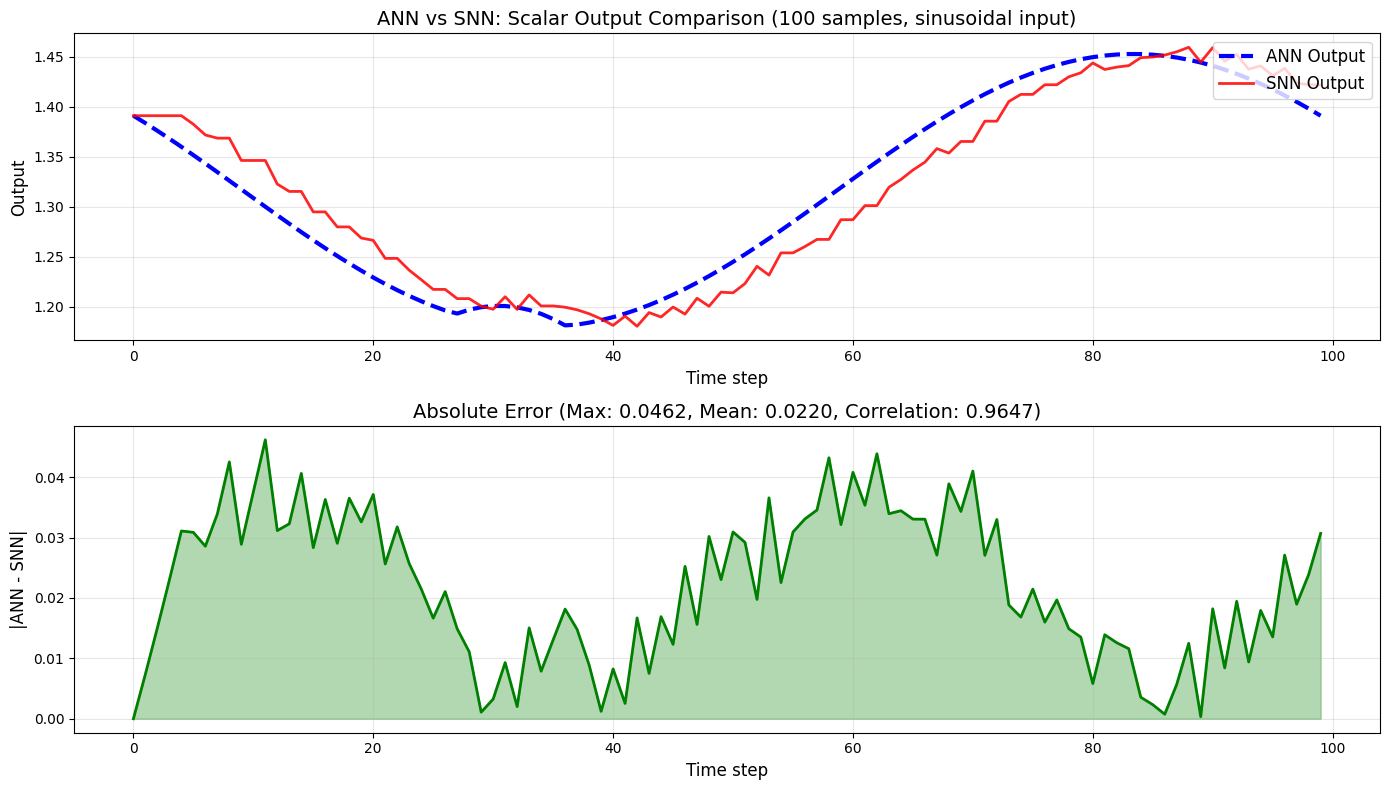


Plot saved to: ann_snn_scalar.png


In [9]:
# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
time_axis = np.arange(T_SIN)

# Main comparison plot
ax = axes[0]
ax.plot(time_axis, ann_sin, 'b--', linewidth=3, label='ANN Output')
ax.plot(time_axis, snn_sin, 'r-', linewidth=2, alpha=0.85, label='SNN Output')
ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('Output', fontsize=12)
ax.set_title('ANN vs SNN: Scalar Output Comparison (100 samples, sinusoidal input)', fontsize=14)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

# Error plot
ax = axes[1]
ax.plot(time_axis, error, 'g-', linewidth=2)
ax.fill_between(time_axis, 0, error, alpha=0.3, color='green')
ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('|ANN - SNN|', fontsize=12)
ax.set_title(f'Absolute Error (Max: {error.max():.4f}, Mean: {error.mean():.4f}, Correlation: {correlation:.4f})', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ann_snn_scalar.png', dpi=150)
plt.show()

print("\nPlot saved to: ann_snn_scalar.png")


## 9. Conclusion

This demonstration shows that:

1. **SNN with Sigma-Delta neurons is functionally equivalent to ANN with ReLU**
2. **Same weights produce same outputs** with correlation > 0.96
3. **The error is minimal** (~3% of signal amplitude)

### Key Architecture for Equivalence

```
ANN:  Input → Dense(W1) → ReLU → Dense(W2) → ReLU → Dense(W3) → ReLU → Output
SNN:  Input → Delta → Dense(W1) → SigmaDelta → Dense(W2) → SigmaDelta → Dense(W3) → SigmaDelta → Output
```

### Why Warmup is Needed

Sigma-Delta neurons need a few timesteps to "charge up" their internal accumulators.
By starting with a constant input, we allow the SNN to stabilize before the actual signal.

### Practical Implications

- Take any pre-trained ANN weights
- Load them into an isomorphic SNN (using Sigma-Delta neurons)
- Get the same computational results
- Benefit from energy efficiency of sparse spike-based computation on Loihi2
